In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import os.path

index_list = [
    "loadtest-webrtc-preliminary-mediasoup-2p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-2p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-5p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-5p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-6p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-6p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-7p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-7p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-8p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-8p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-10p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-10p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-3p-10s-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-3p-10s-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-3p-40s-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-3p-40s-c5xlarge-final"
]

In [26]:
df_list = [ pd.read_csv(f"dfs/{x}.csv") for x in index_list if os.path.isfile(f"dfs/{x}.csv") ]

(0.0, 1.0)

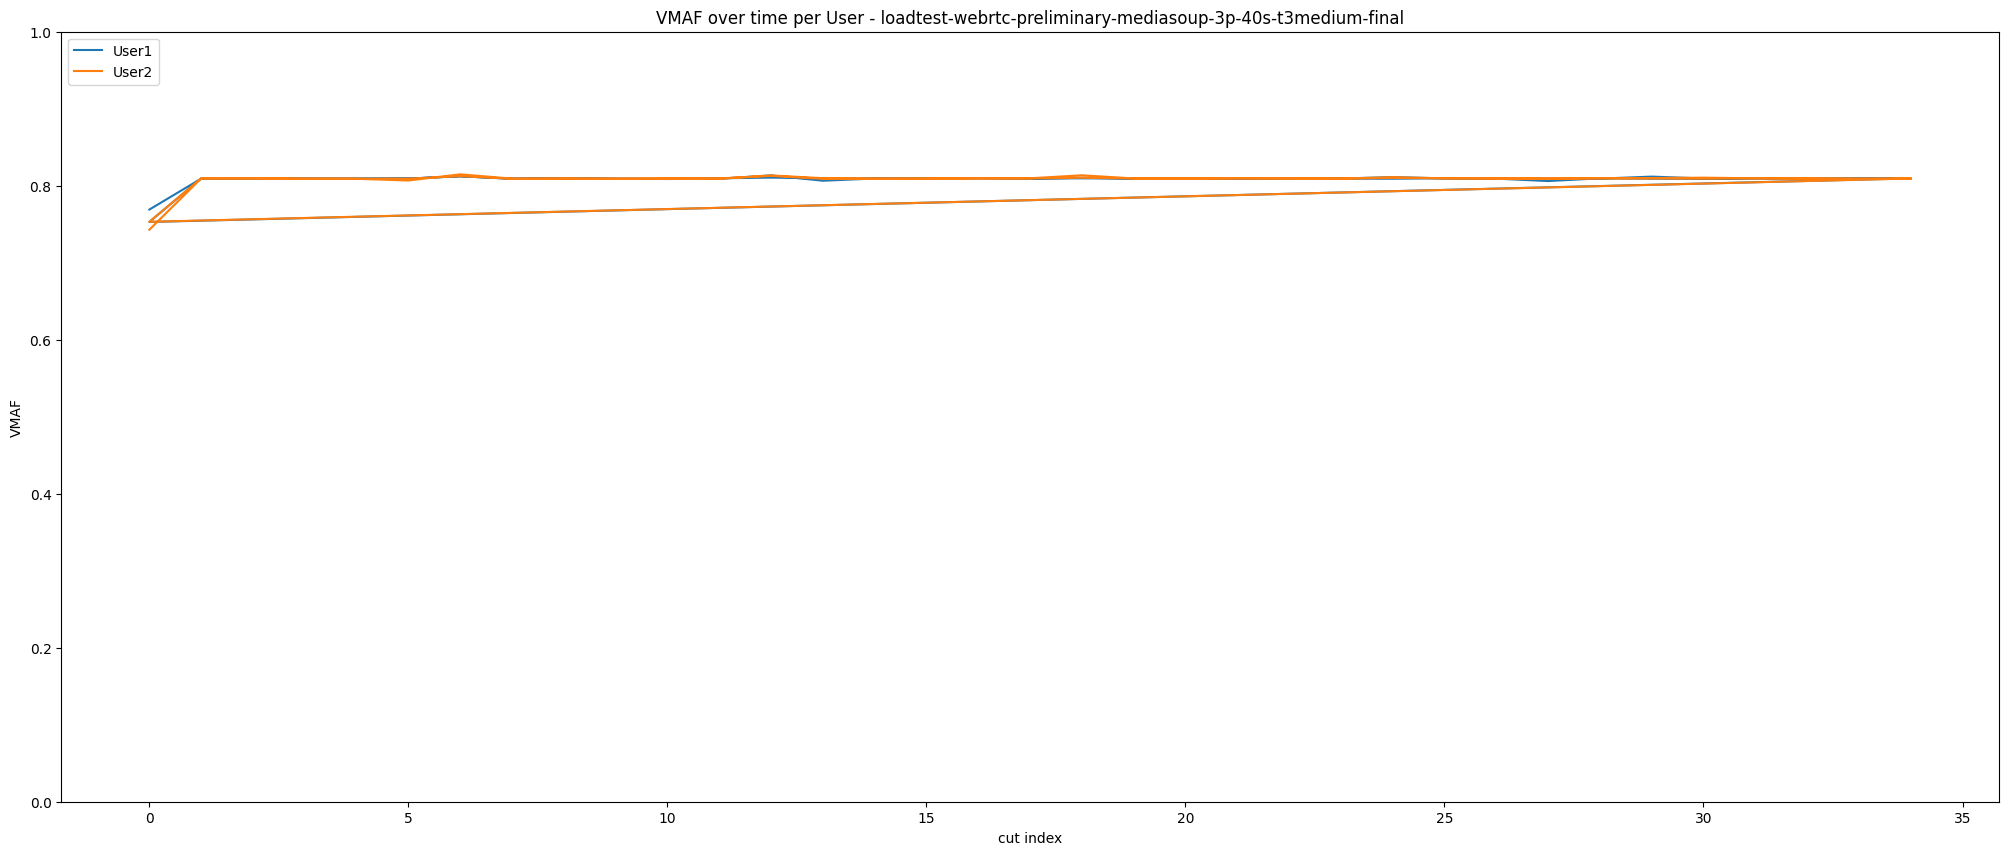

In [27]:
plt.rcParams['figure.figsize'] = [25, 10]
df_user = df_list[14]
df_user1 = df_user[df_user.userFrom == "User1"]
plt.plot(df_user1["cut_index"], df_user1["vmaf"], label="User1")
df_user2 = df_user[df_user.userFrom == "User2"]
plt.plot(df_user2["cut_index"], df_user2["vmaf"], label="User2")

plt.title("VMAF over time per User - " + index_list[14])
plt.xlabel("cut index")
plt.ylabel("VMAF")
plt.legend(loc="upper left")
plt.ylim(0, 1)


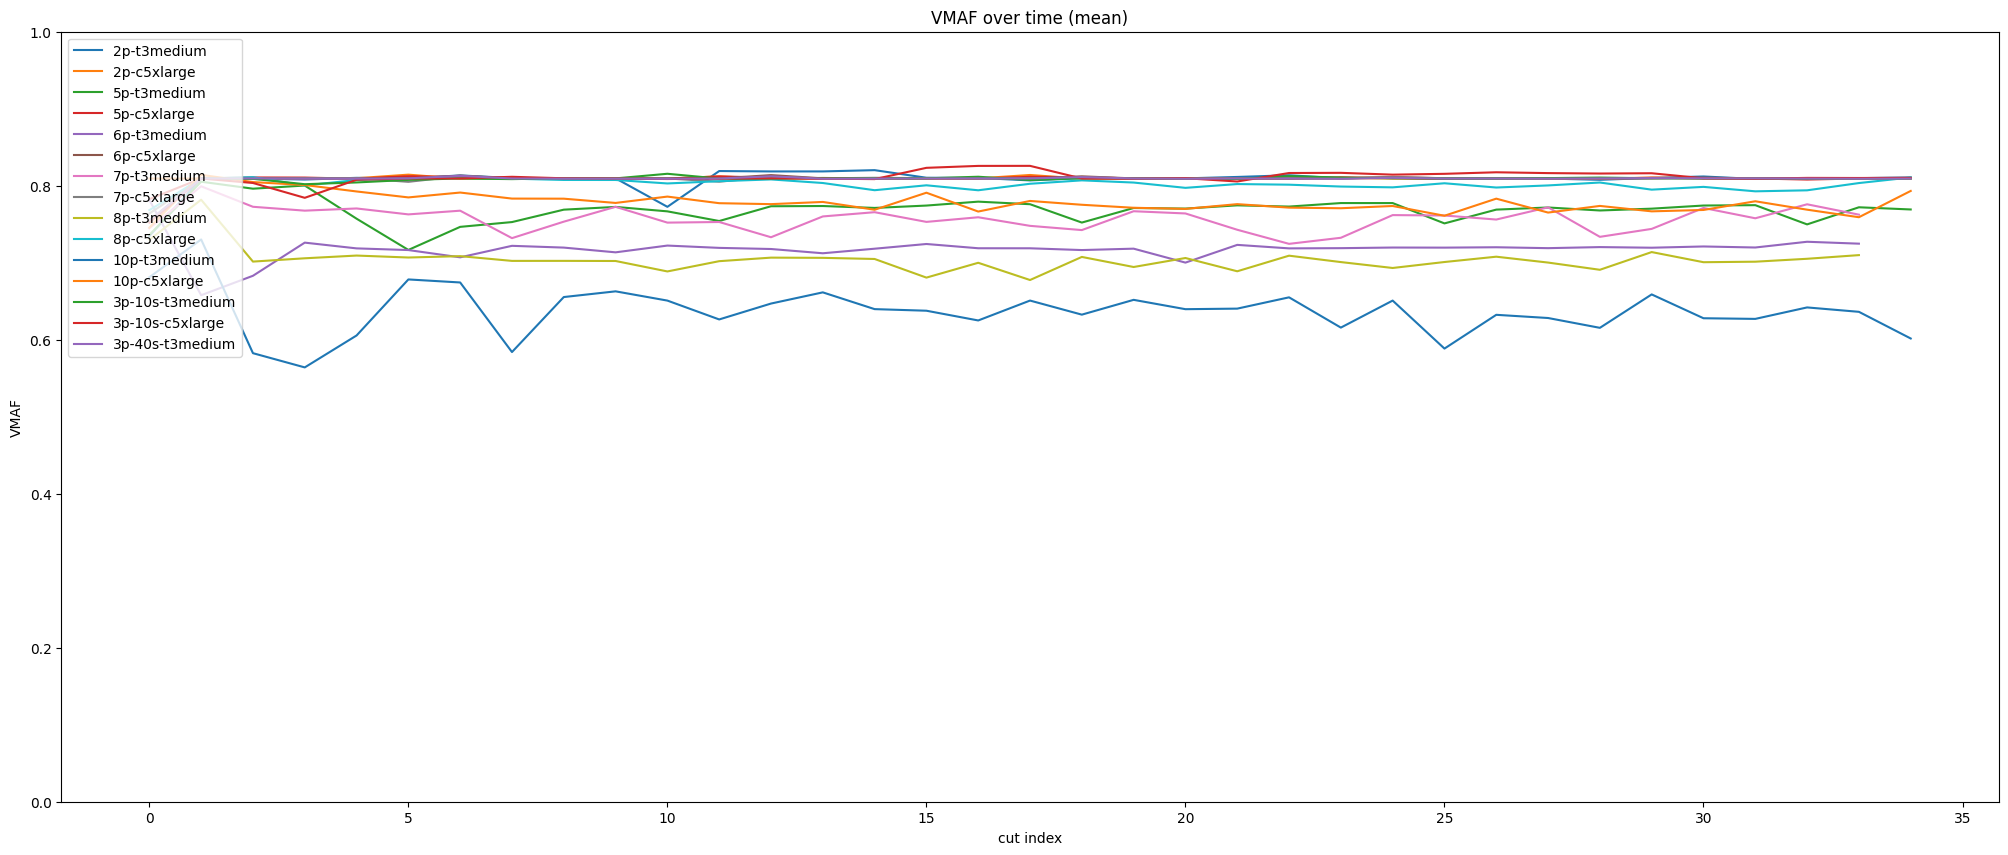

In [28]:
plt.rcParams['figure.figsize'] = [25, 10]


for i, df_tmp in enumerate(df_list):
    df_mean = df_tmp.groupby(["cut_index"]).mean()
    plot_name = index_list[i][38:-6]
    if not df_mean.empty:
        plt.plot(df_mean.index, df_mean["vmaf"], label=plot_name)

plt.title("VMAF over time (mean)")
plt.xlabel("cut index")
plt.ylabel("VMAF")
plt.ylim(0, 1)
plt.legend(loc="upper left")

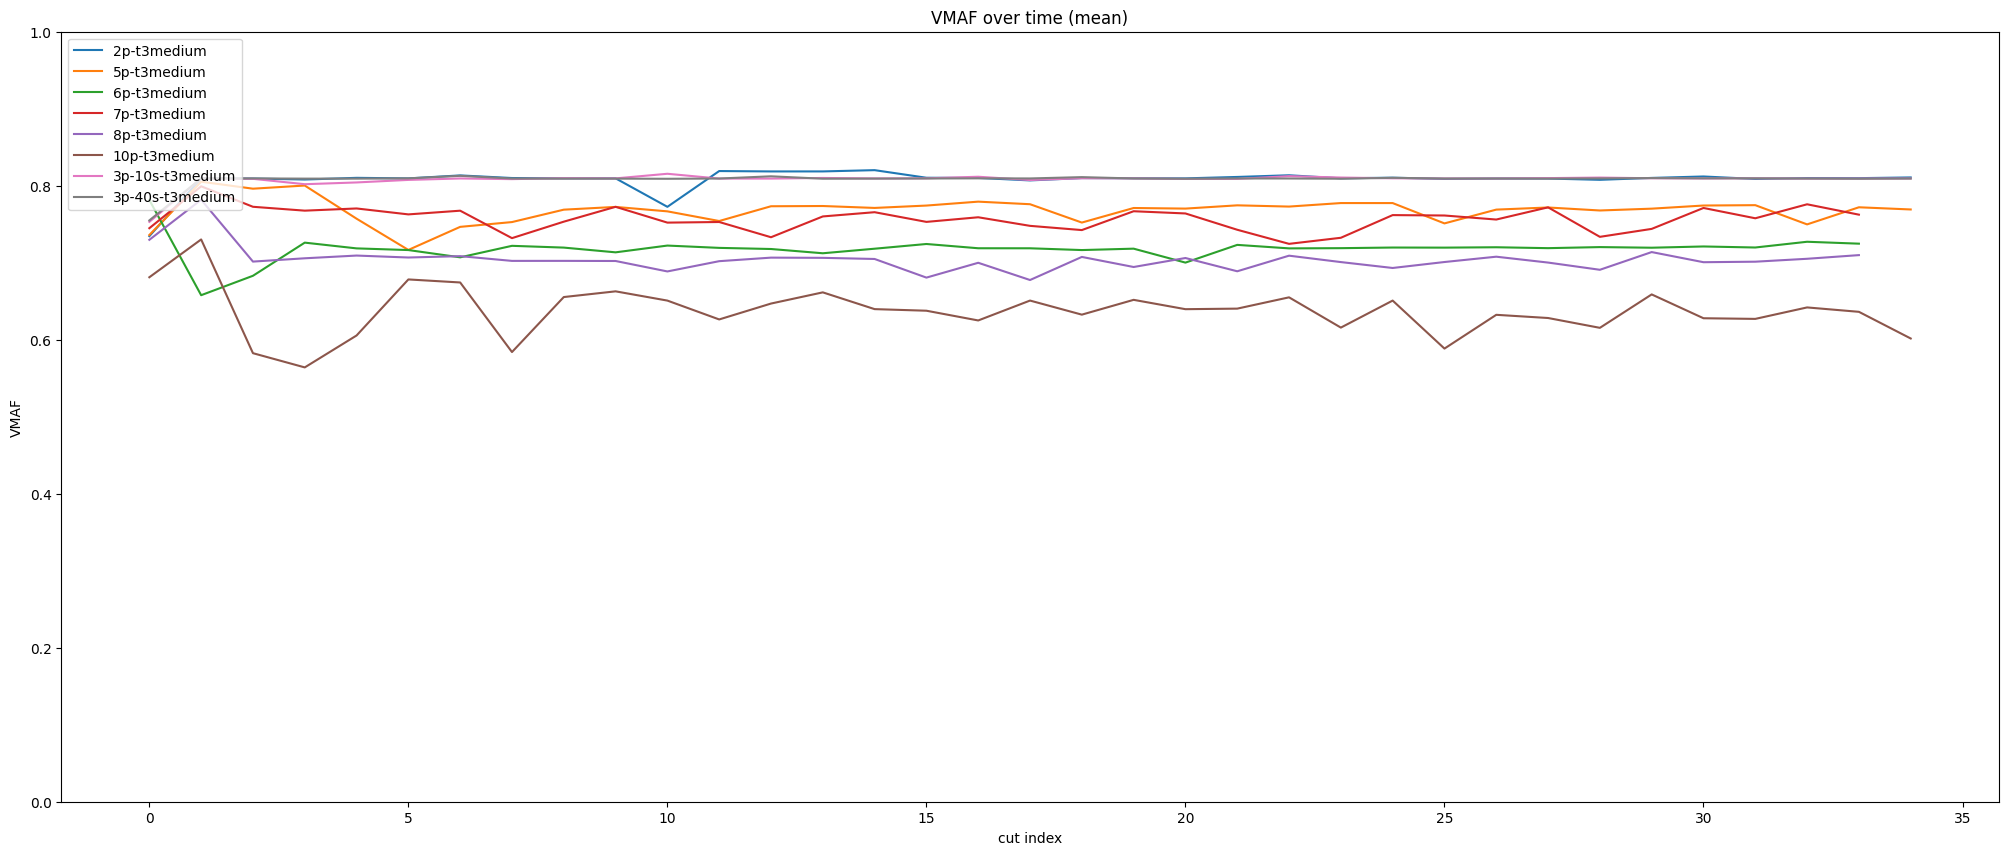

In [29]:
plt.rcParams['figure.figsize'] = [25, 10]


for i, df_tmp in enumerate(df_list):
    if (i % 2 == 0):
        df_mean = df_tmp.groupby(["cut_index"]).mean()
        plot_name = index_list[i][38:-6]
        if not df_mean.empty:
            plt.plot(df_mean.index, df_mean["vmaf"], label=plot_name)

plt.title("VMAF over time (mean)")
plt.xlabel("cut index")
plt.ylabel("VMAF")
plt.ylim(0, 1)
plt.legend(loc="upper left")

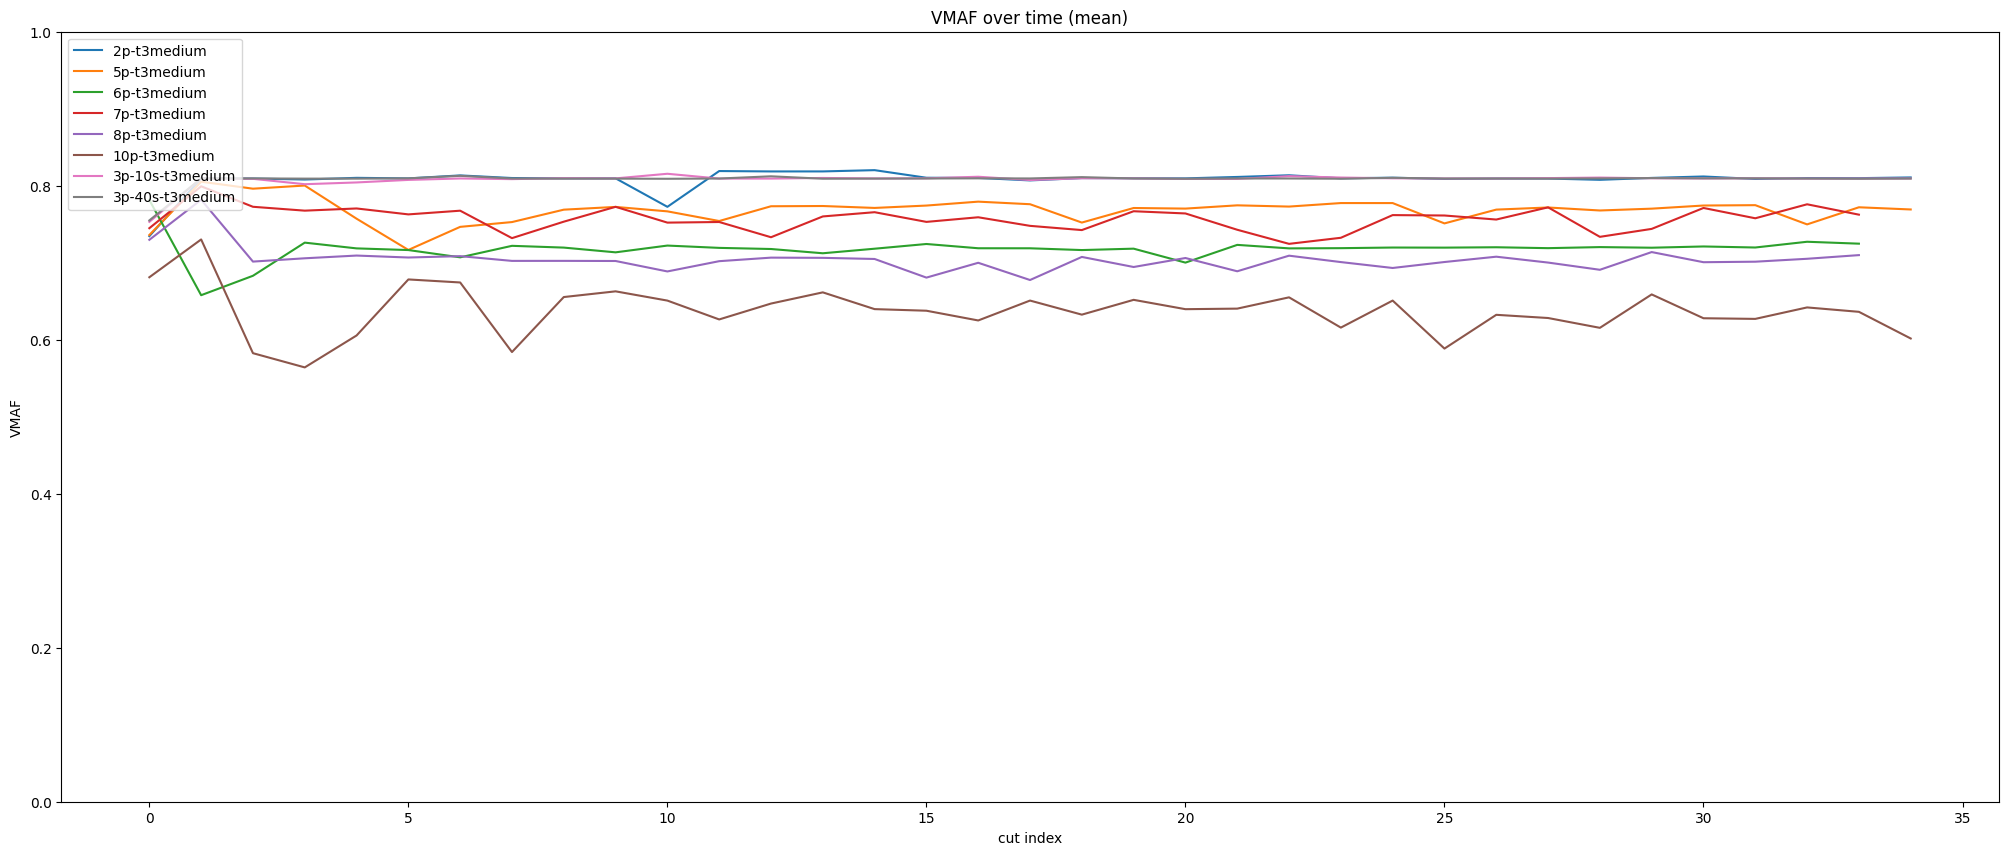

In [30]:
plt.rcParams['figure.figsize'] = [25, 10]


for i, df_tmp in enumerate(df_list):
    if (i % 2 == 0):
        df_mean = df_tmp.groupby(["cut_index"]).mean()
        plot_name = index_list[i][38:-6]
        if not df_mean.empty:
            plt.plot(df_mean.index, df_mean["vmaf"], label=plot_name)

plt.title("VMAF over time (mean)")
plt.xlabel("cut index")
plt.ylabel("VMAF")
plt.ylim(0, 1)
plt.legend(loc="upper left")